<a href="https://colab.research.google.com/github/hyakuroume/-/blob/main/%E9%81%BA%E4%BC%9D%E5%AD%90%E9%85%8D%E5%88%97%E8%A7%A3%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -q pytorch_lightning==2.5.1  monai==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00


In [45]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl

import monai

import h5py

In [16]:
# バージョン確認
print(f" pytorch version : {torch.__version__}\n pytorch lightning : {pl.__version__}\n monai : {monai.__version__}")

 pytorch version : 2.6.0+cu124
 pytorch lightning : 2.5.1
 monai : 1.3.0


In [17]:
# データセットのダウンロード
%%capture
!if [ ! -e seq.h5 ]; then wget https://github.com/japan-medical-ai/medical-ai-course-materials/releases/download/v0.1/seq.h5; fi

In [21]:
!h5dump -n seq.h5

/bin/bash: line 1: h5dump: command not found


In [24]:
# データの確認
def show_hdf5_structure(file_path):
    """HDF5形式のファイル構造を描画する関数

    Args:
        file_path (str): HDF5ファイルのパス

    Prints:
        HDF5ファイルの構造を描画する
    """
    def _print_structure(name, obj):
        """再帰的に構造を出力する"""
        indent = "  " * name.count("/")  # 深さに応じたインデント
        obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
        print(f"{indent}- {name} ({obj_type})")

    with h5py.File(file_path, "r") as hdf:
        print(f"📂 HDF5 structure of '{file_path}':")
        hdf.visititems(_print_structure)


📂 HDF5 structure of 'seq.h5':
- target_labels (Dataset)
- test_in (Dataset)
- test_out (Dataset)
- train_in (Dataset)
- train_out (Dataset)
- valid_in (Dataset)
- valid_out (Dataset)


In [32]:
# データの読み込み
with h5py.File("seq.h5", "r") as hf:
    x_train, t_train = hf["train_in"][()], hf["train_out"][()]
    x_val, t_val = hf["valid_in"][()], hf["valid_out"][()]
    x_test, t_test = hf["test_in"][()], hf["test_out"][()]
    label = hf["target_labels"][()]

In [37]:
# データ数の確認
print(f"train : {x_train.shape} {t_train.shape}")
print(f"val   : {x_val.shape} {t_val.shape}")
print(f"test  : {x_test.shape} {t_test.shape}")

train : (5000, 131072, 4) (5000, 1024, 10)
val   : (500, 131072, 4) (500, 1024, 10)
test  : (500, 131072, 4) (500, 1024, 10)


In [40]:
# ラベルの確認
label

array([b'ENCSR000EQH_1_1', b'ENCSR000EKJ_1_1', b'ENCSR000EOM_2_1',
       b'ENCSR257BGZ_2_2', b'ENCSR937UWI_2_2', b'ENCSR000EPP_2_1',
       b'ENCSR000EPD_1_1', b'ENCSR000EQL_2_1', b'ENCSR000EMI_1_1',
       b'ENCSR083STA_1_2'], dtype='|S29')

In [41]:
x_train[0, :10, :]

array([[False,  True, False, False],
       [False, False, False,  True],
       [ True, False, False, False],
       [False, False, False,  True],
       [ True, False, False, False],
       [False, False, False,  True],
       [False, False,  True, False],
       [False, False, False,  True],
       [False, False,  True, False],
       [ True, False, False, False]])

In [42]:
t_train[0, :5, :]

array([[1.034 , 0.    , 0.9663, 1.952 , 2.576 , 0.1135, 0.1472, 0.65  ,
        0.0697, 1.127 ],
       [0.4507, 0.    , 0.    , 3.232 , 3.793 , 0.9253, 0.895 , 0.    ,
        0.    , 2.152 ],
       [0.7114, 0.    , 0.3726, 6.14  , 6.254 , 1.3   , 0.    , 0.    ,
        0.    , 2.117 ],
       [0.929 , 0.    , 0.622 , 4.08  , 2.861 , 1.004 , 0.    , 1.129 ,
        0.    , 2.66  ],
       [0.1335, 0.    , 0.1277, 4.707 , 0.5234, 0.    , 0.4475, 0.629 ,
        0.3198, 2.492 ]], dtype=float16)

<BarContainer object of 1024 artists>

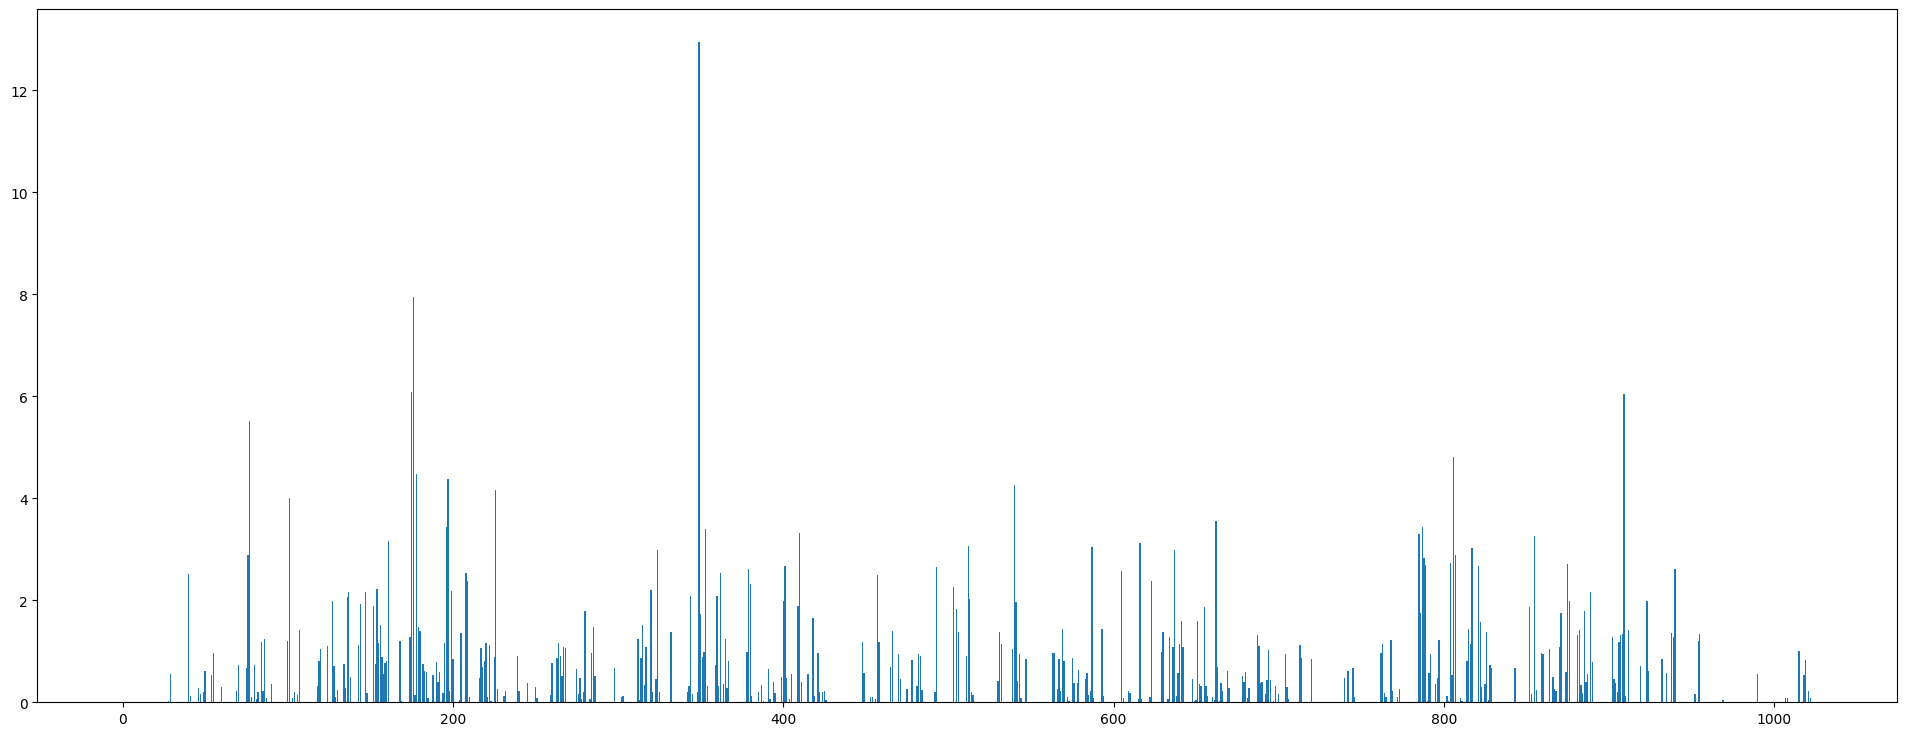

In [44]:
plt.figure(figsize=(24, 9))
value = t_train[0, :, 1]
plt.bar(range(len(value)), value)

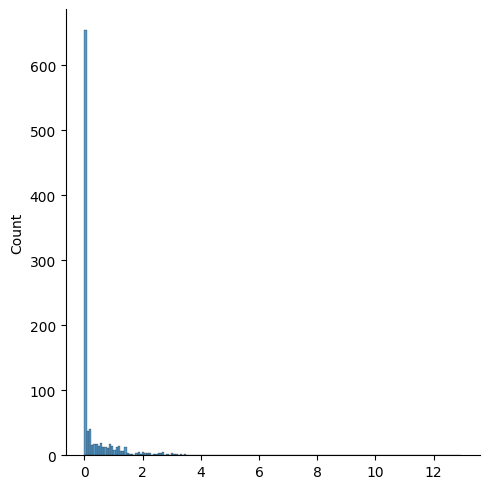

In [47]:
# データの分布をプロット
sns.displot(value)